# Set up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir 'Data'
!unzip 'drive/MyDrive/Kaggle/electric-power-consumption.zip' -d 'Data'

Mounted at /content/drive
Archive:  drive/MyDrive/Kaggle/electric-power-consumption.zip
  inflating: Data/PowerCons_TEST.csv  
  inflating: Data/PowerCons_TRAIN.csv  
  inflating: Data/README.md          
  inflating: Data/forecast_submission_example.csv  


In [ ]:
!pip install statsmodels

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Explore data

In [ ]:
train = pd.read_csv('/content/Data/PowerCons_TRAIN.csv')
test = pd.read_csv('/content/Data/PowerCons_TEST.csv')

train.head()

,Day,00:00,00:10,00:20,00:30,00:40,00:50,01:00,01:10,01:20,01:30,01:40,01:50,02:00,02:10,02:20,02:30,02:40,02:50,03:00,03:10,03:20,03:30,03:40,03:50,04:00,04:10,04:20,04:30,04:40,04:50,05:00,05:10,05:20,05:30,05:40,05:50,06:00,06:10,06:20,...,17:30,17:40,17:50,18:00,18:10,18:20,18:30,18:40,18:50,19:00,19:10,19:20,19:30,19:40,19:50,20:00,20:10,20:20,20:30,20:40,20:50,21:00,21:10,21:20,21:30,21:40,21:50,22:00,22:10,22:20,22:30,22:40,22:50,23:00,23:10,23:20,23:30,23:40,23:50,Class
0,1,0.44,0.40,0.36,0.35,0.35,0.38,0.36,0.35,0.35,0.38,0.38,0.38,0.42,0.45,0.43,0.37,0.66,1.13,1.35,1.09,0.75,0.41,0.37,0.33,0.33,0.40,0.40,0.39,0.40,0.43,0.40,0.35,0.31,0.33,0.33,0.33,0.30,0.30,0.33,...,0.23,0.21,0.20,0.18,0.14,0.25,0.37,0.58,0.70,0.74,0.56,0.38,0.32,0.30,0.32,0.31,0.31,0.85,1.40,1.82,2.24,2.29,2.34,2.38,2.38,1.23,1.23,1.18,1.14,0.77,0.40,0.33,0.29,0.28,0.24,0.22,0.23,0.25,0.25,1
1,2,0.14,0.19,0.19,0.16,0.16,0.18,0.17,0.16,0.17,0.17,0.16,0.18,0.18,0.14,0.13,0.16,0.19,0.14,0.15,0.18,0.18,0.15,0.16,0.19,0.17,0.16,0.16,0.17,0.16,0.18,0.17,0.14,0.15,0.17,0.18,0.10,0.37,0.64,0.89,...,0.21,0.20,0.22,0.71,1.20,1.21,1.26,1.33,1.41,1.48,1.15,0.83,0.62,0.40,0.37,0.32,0.26,0.23,0.25,0.24,0.23,0.23,0.25,0.25,0.21,0.22,0.26,0.29,0.39,0.48,0.62,0.39,0.17,0.14,0.70,1.25,1.21,1.20,1.24,1
2,3,0.34,0.34,0.34,0.26,0.18,0.83,1.48,1.36,0.95,0.55,0.42,0.29,0.26,0.24,0.24,0.25,0.23,0.25,0.26,0.25,0.25,0.26,0.28,0.30,0.33,0.31,0.30,0.27,0.25,0.22,0.20,0.22,0.24,0.22,0.19,0.22,0.24,0.24,0.25,...,0.32,0.32,0.32,0.28,0.28,0.26,0.25,0.26,0.27,0.24,0.21,0.21,0.21,0.23,0.24,0.93,1.62,2.12,2.63,2.63,1.18,1.18,1.01,0.83,0.78,0.74,0.72,0.71,0.70,0.84,0.97,1.23,1.49,1.17,0.85,0.83,0.79,0.75,0.73,1
3,4,1.70,1.50,1.30,3.40,5.50,4.15,2.80,2.67,2.53,2.49,2.45,2.41,1.64,0.88,0.53,0.19,0.17,0.16,0.16,0.22,0.29,0.19,0.14,0.15,0.21,0.26,0.26,0.22,0.21,0.24,0.26,0.29,0.22,0.17,0.13,0.19,0.24,0.16,0.13,...,0.75,0.51,0.64,0.48,0.31,1.46,2.60,1.44,0.27,0.35,0.44,0.46,0.47,0.48,1.01,1.54,1.75,1.97,1.89,1.81,1.67,1.54,1.49,1.43,1.41,1.43,1.44,1.53,1.61,1.62,1.61,1.60,1.59,1.55,1.00,0.55,0.37,0.37,0.36,1
4,5,1.78,1.59,1.39,1.45,1.45,1.41,1.40,1.45,1.46,1.40,0.85,0.30,0.34,0.38,0.33,0.33,0.39,0.35,0.31,0.31,0.35,0.38,0.38,0.33,0.33,0.38,0.39,0.35,0.33,0.36,0.38,0.37,0.34,0.34,0.37,0.37,0.35,0.35,0.37,...,0.26,0.27,0.28,0.29,0.33,0.39,0.37,0.31,0.27,0.28,0.29,0.29,0.24,0.25,0.30,0.30,0.26,0.25,0.28,0.31,0.30,0.31,0.34,0.36,0.35,0.32,0.31,0.32,0.84,1.36,1.36,1.40,0.81,0.23,0.27,0.29,0.28,0.27,0.27,1


In [ ]:
test.head()

,Day,00:00,00:10,00:20,00:30,00:40,00:50,01:00,01:10,01:20,01:30,01:40,01:50,02:00,02:10,02:20,02:30,02:40,02:50,03:00,03:10,03:20,03:30,03:40,03:50,04:00,04:10,04:20,04:30,04:40,04:50,05:00,05:10,05:20,05:30,05:40,05:50,06:00,06:10,06:20,06:30,06:40,06:50,07:00,07:10,07:20,07:30,07:40,07:50,08:00,08:10,08:20,08:30,08:40,08:50,09:00,09:10,09:20,09:30,09:40,09:50,10:00,10:10,10:20,10:30,10:40,10:50,11:00,11:10,11:20,11:30,11:40,11:50
0,1,0.34,0.31,0.30,0.29,0.29,0.30,0.31,0.80,1.28,1.34,1.40,0.83,0.27,0.27,0.33,0.32,0.22,0.31,0.31,0.30,0.29,0.28,0.26,0.27,0.28,0.22,0.30,0.37,0.30,0.22,0.25,0.28,0.26,0.24,0.25,0.26,0.29,0.31,0.28,0.24,1.02,1.80,1.47,1.74,2.01,2.39,2.76,2.76,1.53,1.53,1.39,1.36,1.32,1.34,1.31,1.28,1.27,1.27,1.31,1.34,1.33,1.32,0.82,0.32,0.32,0.27,0.27,0.27,0.38,0.38,1.12,1.86
1,2,0.35,0.35,0.35,0.35,0.39,0.39,0.35,0.32,0.34,0.35,0.37,0.36,0.35,0.35,0.38,0.38,0.34,0.29,0.29,0.30,0.32,0.35,0.32,0.34,0.36,0.31,0.26,0.26,0.26,0.32,0.38,0.31,0.24,0.24,0.30,0.30,0.32,0.34,0.34,0.34,1.54,2.74,2.21,1.69,1.71,1.73,1.31,0.89,1.54,2.20,1.95,1.70,1.79,1.80,1.82,1.54,1.44,1.35,1.44,1.39,1.33,1.33,1.34,1.34,1.34,1.13,0.77,0.42,0.42,0.36,0.36,0.94
2,3,2.19,1.91,1.63,0.99,0.34,0.29,0.29,0.30,0.30,0.27,0.25,0.27,0.28,0.28,0.27,0.27,0.30,0.30,0.26,0.22,0.23,0.24,0.26,0.28,0.28,0.38,0.38,0.31,0.23,0.23,0.23,0.27,0.31,0.31,0.28,0.28,0.30,0.31,0.57,0.83,1.60,2.13,2.65,2.67,2.69,2.73,2.76,2.78,2.86,2.95,2.33,1.70,2.11,1.92,1.73,1.51,1.28,1.37,1.40,1.43,1.43,1.36,1.36,1.35,1.33,1.29,1.29,1.40,1.40,1.48,1.57,1.89
3,4,3.66,3.23,2.87,2.50,1.85,1.74,1.63,1.47,1.19,0.91,0.53,0.34,0.14,0.16,0.17,0.17,0.18,0.20,0.20,0.20,0.20,0.21,0.22,0.24,0.20,0.17,0.19,0.20,0.16,0.12,0.13,0.16,0.19,0.18,0.17,0.20,0.19,0.18,0.17,0.16,0.18,0.19,0.16,0.12,0.35,0.57,0.85,1.14,1.14,1.20,1.20,1.20,2.05,2.90,1.60,0.30,1.30,2.29,1.38,0.46,0.88,1.31,1.29,1.28,2.56,3.84,3.01,2.18,2.68,3.17,3.11,3.06
4,5,0.44,0.33,0.23,0.18,0.19,0.23,0.26,0.25,0.24,0.22,0.21,0.20,0.19,0.15,0.70,1.26,1.20,0.79,0.38,0.25,0.18,0.19,0.22,0.20,0.18,0.20,0.21,0.20,0.21,0.19,0.19,0.22,0.22,0.17,0.18,0.22,0.21,0.18,0.19,0.21,0.21,0.69,1.17,0.80,0.43,0.66,0.88,1.11,1.33,1.22,1.12,0.88,0.64,0.39,0.15,0.18,0.19,0.19,0.20,0.17,0.17,0.20,0.20,0.16,0.17,0.20,0.20,0.18,0.18,0.19,0.19,0.20


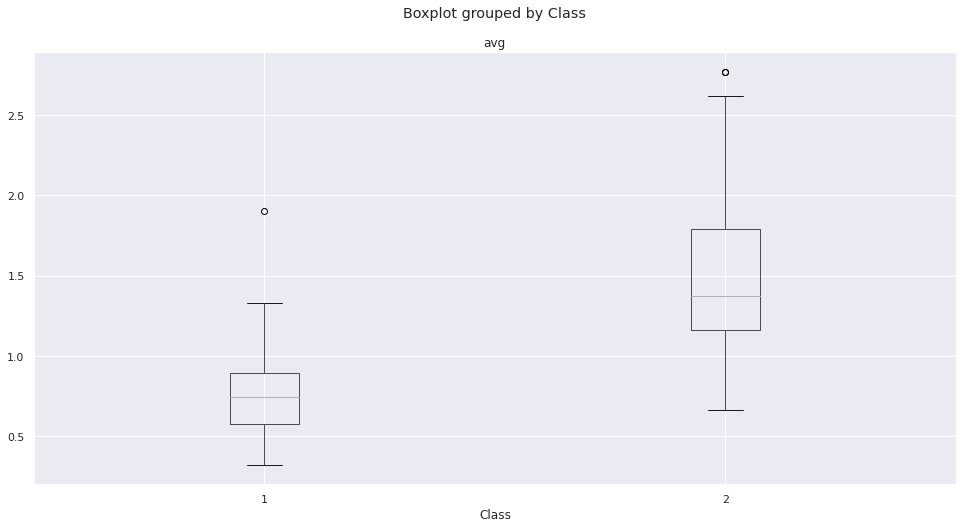

In [ ]:
train['avg'] = train.drop(['Day','Class'],axis=1).mean(axis=1).round(2)

train.boxplot(column='avg',by='Class',figsize=(16,8))

ช่วงฤดูหนาวจะมีการใช้ไฟมากกว่าฤดูร้อน เพราะงั้นเราไม่สามารถ ignore ตัวแปร class ได้ใน model ของเรา

In [ ]:
def multi_day_plot(day_list):
  fig,ax=plt.subplots(4,4)
  fig.set_size_inches(20, 20)

  count=0
  for i in range(4):
    for j in range(4):
      if count < len(day_list):
        data=train.iloc[day_list[count]-1,1:73]
        ax[i,j].plot(range(len(data)),data)
        ax[i,j].set_xticks([0,24,48,72,96,120,144])
        ax[i,j].set_xticklabels(['00:00','04:00','08:00','12:00','16:00','20:00','24:00'])
        ax[i,j].set_ylim(0,6)
        ax[i,j].set_ylim(0,6)
        ax[i,j].set_title('Day {}'.format(day_list[count]+1))
        count+=1
        
  plt.show()

เนื่องจากข้อมูล test set มีแค่ครึ่งวัน เราจึงลองพลอตกราฟครึ่งวันดู เพื่อเช็คว่ามันมีสัญญาณอะไรบ่งบอกไหมว่าวันไหนเป็นหน้าร้อน(Class=1) วันไหนเป็นหน้าหนาว(Class=2)

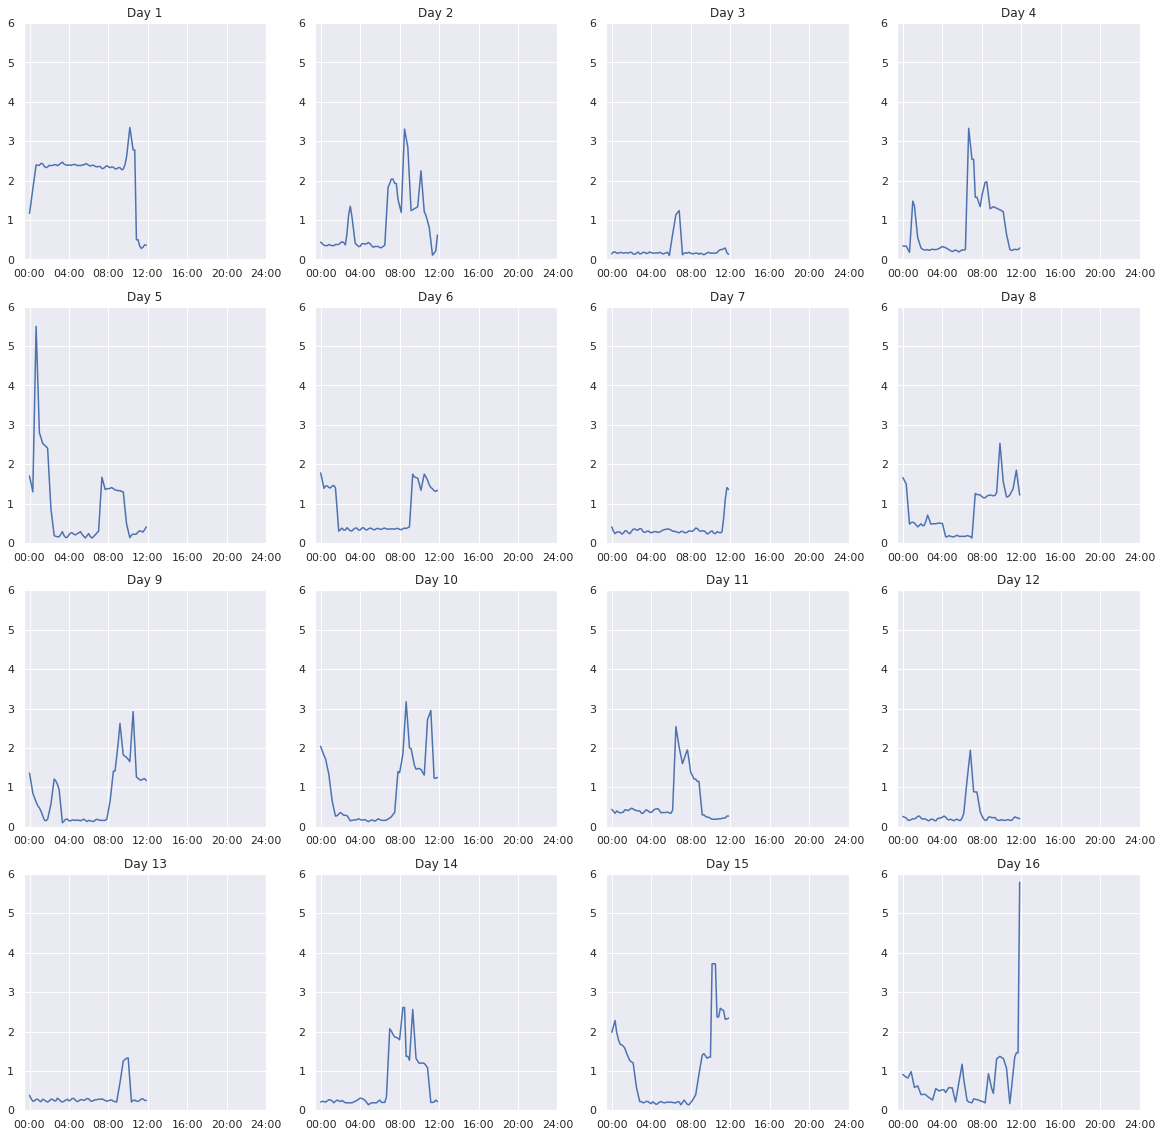

In [ ]:
multi_day_plot(range(16))

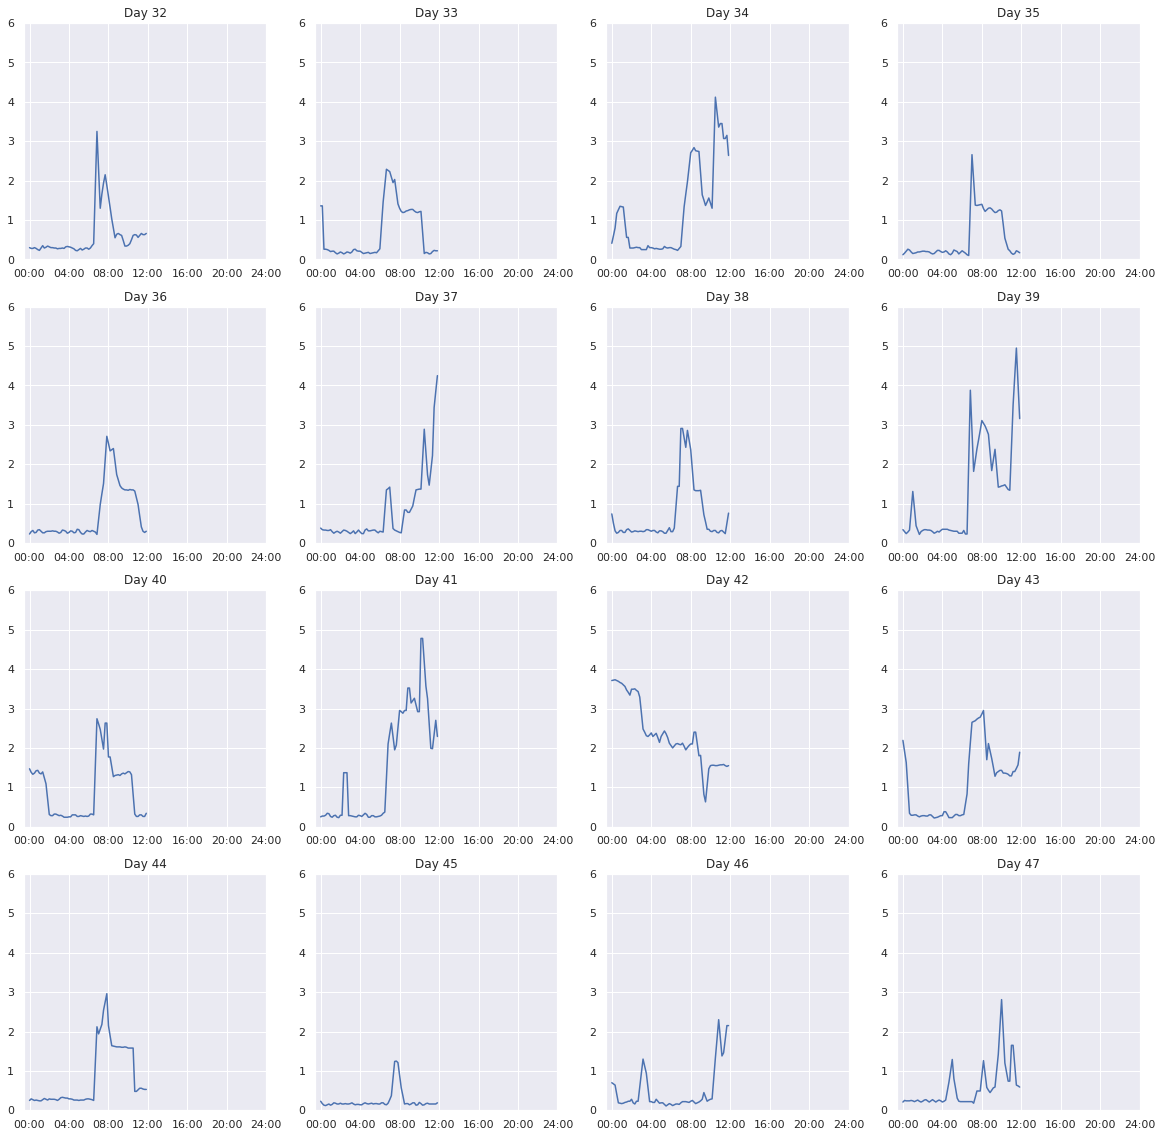

In [ ]:
multi_day_plot(range(31,47))

จะเห็นได้ว่าหากพลอตกราฟแค่ครึ่งวัน สามารถพูดได้ยากว่าวันนั้นเป็นหน้าร้อนหรือหน้าหนาว

คำนวณผลรวมการใช้ไฟในครึ่งหลังของวัน

In [ ]:
half_train=train.iloc[:,1:73]
another_half_train=train.iloc[:,73:len(train.columns)-2]
half_train['kW-12:00-23:50']=another_half_train.sum(axis=1)
half_train['Class']=train['Class']
half_train

,00:00,00:10,00:20,00:30,00:40,00:50,01:00,01:10,01:20,01:30,01:40,01:50,02:00,02:10,02:20,02:30,02:40,02:50,03:00,03:10,03:20,03:30,03:40,03:50,04:00,04:10,04:20,04:30,04:40,04:50,05:00,05:10,05:20,05:30,05:40,05:50,06:00,06:10,06:20,06:30,06:40,06:50,07:00,07:10,07:20,07:30,07:40,07:50,08:00,08:10,08:20,08:30,08:40,08:50,09:00,09:10,09:20,09:30,09:40,09:50,10:00,10:10,10:20,10:30,10:40,10:50,11:00,11:10,11:20,11:30,11:40,11:50,kW-12:00-23:50,Class
0,0.44,0.40,0.36,0.35,0.35,0.38,0.36,0.35,0.35,0.38,0.38,0.38,0.42,0.45,0.43,0.37,0.66,1.13,1.35,1.09,0.75,0.41,0.37,0.33,0.33,0.40,0.40,0.39,0.40,0.43,0.40,0.35,0.31,0.33,0.33,0.33,0.30,0.30,0.33,0.36,1.10,1.83,1.93,2.04,2.04,1.93,1.93,1.53,1.36,1.19,2.25,3.31,3.08,2.85,2.04,1.24,1.26,1.29,1.31,1.34,1.79,2.25,1.73,1.21,1.12,0.97,0.82,0.47,0.11,0.16,0.22,0.62,41.55,1
1,0.14,0.19,0.19,0.16,0.16,0.18,0.17,0.16,0.17,0.17,0.16,0.18,0.18,0.14,0.13,0.16,0.19,0.14,0.15,0.18,0.18,0.15,0.16,0.19,0.17,0.16,0.16,0.17,0.16,0.18,0.17,0.14,0.15,0.17,0.18,0.10,0.37,0.64,0.89,1.14,1.19,1.24,0.68,0.12,0.16,0.17,0.16,0.18,0.16,0.14,0.15,0.16,0.16,0.13,0.16,0.14,0.12,0.14,0.17,0.18,0.16,0.16,0.16,0.16,0.17,0.22,0.25,0.25,0.27,0.29,0.17,0.13,29.03,1
2,0.34,0.34,0.34,0.26,0.18,0.83,1.48,1.36,0.95,0.55,0.42,0.29,0.26,0.24,0.24,0.25,0.23,0.25,0.26,0.25,0.25,0.26,0.28,0.30,0.33,0.31,0.30,0.27,0.25,0.22,0.20,0.22,0.24,0.22,0.19,0.22,0.24,0.24,0.25,1.79,3.33,2.94,2.54,2.54,1.58,1.58,1.46,1.34,1.61,1.79,1.96,1.97,1.63,1.29,1.31,1.34,1.32,1.30,1.28,1.26,1.24,1.21,0.92,0.64,0.45,0.26,0.23,0.24,0.26,0.25,0.25,0.29,51.77,1
3,1.70,1.50,1.30,3.40,5.50,4.15,2.80,2.67,2.53,2.49,2.45,2.41,1.64,0.88,0.53,0.19,0.17,0.16,0.16,0.22,0.29,0.19,0.14,0.15,0.21,0.26,0.26,0.22,0.21,0.24,0.26,0.29,0.22,0.17,0.13,0.19,0.24,0.16,0.13,0.17,0.21,0.26,0.30,0.99,1.67,1.52,1.36,1.38,1.38,1.39,1.41,1.38,1.35,1.34,1.33,1.33,1.31,1.30,0.89,0.49,0.31,0.14,0.20,0.23,0.22,0.23,0.28,0.31,0.30,0.28,0.34,0.41,68.13,1
4,1.78,1.59,1.39,1.45,1.45,1.41,1.40,1.45,1.46,1.40,0.85,0.30,0.34,0.38,0.33,0.33,0.39,0.35,0.31,0.31,0.35,0.38,0.38,0.33,0.33,0.38,0.39,0.35,0.33,0.36,0.38,0.37,0.34,0.34,0.37,0.37,0.35,0.35,0.37,0.38,0.36,0.35,0.36,0.36,0.36,0.35,0.37,0.37,0.35,0.34,0.36,0.38,0.37,0.39,0.41,1.08,1.75,1.68,1.66,1.65,1.50,1.34,1.55,1.75,1.68,1.60,1.48,1.41,1.38,1.33,1.31,1.34,31.58,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.39,0.38,0.34,0.29,0.27,0.26,0.24,0.25,0.26,0.82,1.37,1.30,1.16,1.03,0.66,0.29,0.28,0.27,0.27,0.27,0.28,0.30,0.31,0.31,0.28,0.25,0.28,0.31,0.35,0.35,0.30,0.30,0.31,0.27,0.24,0.29,0.28,0.27,0.28,0.30,1.23,2.16,2.08,2.00,2.01,2.01,2.06,2.11,2.18,2.24,2.55,2.86,2.71,2.56,2.38,2.19,2.11,2.02,1.81,1.71,1.61,1.57,1.54,2.61,3.68,3.73,3.27,2.81,2.22,1.63,1.66,1.69,123.28,2
176,0.71,0.49,0.27,0.31,0.36,0.43,0.42,0.40,0.31,0.27,0.22,0.24,0.26,0.27,0.30,0.34,0.30,0.25,0.28,0.27,0.25,0.25,0.27,0.25,0.23,0.23,0.71,1.20,1.26,1.31,1.12,0.68,0.25,0.27,0.29,0.24,0.23,0.30,0.38,0.29,1.42,2.55,2.58,2.38,2.19,2.43,2.68,2.23,1.78,2.20,2.61,1.51,0.41,0.36,0.30,0.41,0.75,1.09,0.77,0.44,0.46,0.48,0.42,0.35,0.37,0.39,0.47,0.52,0.56,0.71,0.85,0.77,114.79,2
177,0.39,0.31,0.26,0.30,0.39,0.38,0.31,0.26,0.29,0.32,0.30,0.26,0.27,0.31,0.32,0.28,0.29,0.35,0.38,0.33,0.28,0.28,0.29,0.29,0.27,0.28,0.29,0.30,0.27,0.30,0.35,0.36,0.31,0.27,0.28,0.32,0.69,1.06,1.40,1.75,1.90,2.06,4.93,7.80,5.55,3.30,2.70,2.10,2.19,2.29,1.85,1.41,1.43,1.41,2.02,2.64,2.01,1.38,1.36,1.39,1.43,1.41,1.36,1.32,1.36,1.39,1.37,1.33,1.34,1.39,1.40,1.38,177.00,2
178,0.41,0.34,0.29,0.23,0.27,0.32,0.25,0.24,0.28,0.32,0.32,0.29,0.33,0.36,0.31,0.26,0.24,0.27,0.27,0.27,0.28,0.31,0.33,0.31,0.26,0.23,0.24,0.25,0.27,0.25,0.25,0.31,0.37,0.30,0.22,0.23,0.27,0.31,0.25,0.25,0.29,1.96,3.63,2.88,2.13,2.19,1.95,1.71,1.71,1.71,1.60,1.50,1.05,0.60,0.5

ทดสอบว่าใช้ OLS regression กับข้อมูลดีไหม

In [ ]:
ols_input='Q("kW-12:00-23:50")'
for column in half_train.columns:
  if column!="kW-12:00-23:50":
    if column=='00:00':
      ols_input+=' ~ '+'Q'+'("'+column+'")'+'+ '
    elif column=='Class':
      ols_input+=column
    else:
      ols_input+='Q'+'("'+column+'")'+'+ '

lr = smf.ols(ols_input, data=half_train).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Q("kW-12:00-23:50")   R-squared:                       0.873
Model:                             OLS   Adj. R-squared:                  0.786
Method:                  Least Squares   F-statistic:                     10.02
Date:                 Sun, 27 Feb 2022   Prob (F-statistic):           1.57e-25
Time:                         07:38:45   Log-Likelihood:                -782.29
No. Observations:                  180   AIC:                             1713.
Df Residuals:                      106   BIC:                             1949.
Df Model:                           73                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -34.3065      8.332     -4.117      0.000     -50.826     -17.787
Q("00:00")   -33.8663     19.586     -1.729      0.087     -72.697       4.965
Q("00:10")    48.0875     29.847      1.611      0.110     -11.088     107.263
Q("00:20")    28.2029     27.993      1.007      0.316     -27.297      83.702
Q("00:30")   -99.3746     42.414     -2.343      0.021    -183.464     -15.285
Q("00:40")    40.4235     35.193      1.149      0.253     -29.350     110.197
Q("00:50")    51.4812     43.840      1.174      0.243     -35.436     138.399
Q("01:00")   -87.3831     51.170     -1.708      0.091    -188.832      14.066
Q("01:10")    36.0058     33.852      1.064      0.290     -31.110     103.121
Q("01:20")    37.9278     28.244      1.343      0.182     -18.068      93.924
Q("01:30")   -75.8022     39.471     -1.920      0.057    -154.058       2.453
Q("01:40")    97.1972     39.578      2.456      0.016      18.730     175.664
Q("01:50")   -90.8503     50.951     -1.783      0.077    -191.866      10.166
Q("02:00")    40.0550     56.158      0.713      0.477     -71.284     151.394
Q("02:10")     9.5138     45.446      0.209      0.835     -80.587      99.614
Q("02:20")    14.5580     34.006      0.428      0.669     -52.863      81.979
Q("02:30")     2.5178     38.603      0.065      0.948     -74.017      79.052
Q("02:40")   -16.3882     45.291     -0.362      0.718    -106.182      73.406
Q("02:50")    19.6030     62.145      0.315      0.753    -103.607     142.812
Q("03:00")   -19.1173     67.421     -0.284      0.777    -152.786     114.551
Q("03:10")    16.9011     72.355      0.234      0.816    -126.550     160.353
Q("03:20")     2.6737     70.233      0.038      0.970    -136.569     141.917
Q("03:30")   -28.0046     88.960     -0.315      0.754    -204.376     148.367
Q("03:40")    42.3050    110.087      0.384      0.702    -175.953     260.563
Q("03:50")   -17.5673    117.195     -0.150      0.881    -249.917     214.782
Q("04:00")     3.1204     96.057      0.032      0.974    -187.323     193.563
Q("04:10")   -18.1719     93.651     -0.194      0.847    -203.844     167.500
Q("04:20")    57.4857    127.279      0.452      0.652    -194.857     309.828
Q("04:30")   -37.7901     92.796     -0.407      0.685    -221.767     146.187
Q("04:40")    18.8462     50.961      0.370      0.712     -82.190     119.882
Q("04:50")   -28.6992     50.470     -0.569      0.571    -128.762      71.363
Q("05:00")     8.7030     43.373      0.201      0.841     -77.288      94.695
Q("05:10")    52.7431     49.327      1.069      0.287     -45.053     150.539
Q("05:20")  -101.9143     77.591     -1.313      0.192    -255.746      51.917
Q("05:30")    73.5997     94.394      0.780      0.437    -113.545     260.744
Q("05:40")    14.1282     65.979      0.214      0.831    -116.682    

จากคำเตือนที่ 2 บอกว่ามีปัญหา multicollinearity ข้อมูลจึงยังไม่พร้อมสำหรับการเทรน model OLS regression

ลองหา difference ของช่วงเวลาในแต่ละวัน

In [ ]:
df=pd.DataFrame()
first=list(half_train.columns)[:-3]
second=list(half_train.columns)[1:-2]
for t1,t2 in zip(first,second):
  df=pd.concat([df,half_train[t2]-half_train[t1]],axis=1)
df.columns=['t'+str(i) for i in range(len(half_train.columns)-3)]
df=pd.concat([df,half_train['Class'],half_train['kW-12:00-23:50']],axis=1)
df

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16,t17,t18,t19,t20,t21,t22,t23,t24,t25,t26,t27,t28,t29,t30,t31,t32,t33,t34,t35,t36,t37,t38,t39,t40,t41,t42,t43,t44,t45,t46,t47,t48,t49,t50,t51,t52,t53,t54,t55,t56,t57,t58,t59,t60,t61,t62,t63,t64,t65,t66,t67,t68,t69,t70,Class,kW-12:00-23:50
0,-0.04,-0.04,-0.01,0.00,0.03,-0.02,-0.01,0.00,0.03,0.00,0.00,0.04,0.03,-0.02,-0.06,0.29,0.47,0.22,-0.26,-0.34,-0.34,-0.04,-0.04,0.00,0.07,0.00,-0.01,0.01,0.03,-0.03,-0.05,-0.04,0.02,0.00,0.00,-0.03,0.00,0.03,0.03,0.74,0.73,0.10,0.11,0.00,-0.11,0.00,-0.40,-0.17,-0.17,1.06,1.06,-0.23,-0.23,-0.81,-0.80,0.02,0.03,0.02,0.03,0.45,0.46,-0.52,-0.52,-0.09,-0.15,-0.15,-0.35,-0.36,0.05,0.06,0.40,1,41.55
1,0.05,0.00,-0.03,0.00,0.02,-0.01,-0.01,0.01,0.00,-0.01,0.02,0.00,-0.04,-0.01,0.03,0.03,-0.05,0.01,0.03,0.00,-0.03,0.01,0.03,-0.02,-0.01,0.00,0.01,-0.01,0.02,-0.01,-0.03,0.01,0.02,0.01,-0.08,0.27,0.27,0.25,0.25,0.05,0.05,-0.56,-0.56,0.04,0.01,-0.01,0.02,-0.02,-0.02,0.01,0.01,0.00,-0.03,0.03,-0.02,-0.02,0.02,0.03,0.01,-0.02,0.00,0.00,0.00,0.01,0.05,0.03,0.00,0.02,0.02,-0.12,-0.04,1,29.03
2,0.00,0.00,-0.08,-0.08,0.65,0.65,-0.12,-0.41,-0.40,-0.13,-0.13,-0.03,-0.02,0.00,0.01,-0.02,0.02,0.01,-0.01,0.00,0.01,0.02,0.02,0.03,-0.02,-0.01,-0.03,-0.02,-0.03,-0.02,0.02,0.02,-0.02,-0.03,0.03,0.02,0.00,0.01,1.54,1.54,-0.39,-0.40,0.00,-0.96,0.00,-0.12,-0.12,0.27,0.18,0.17,0.01,-0.34,-0.34,0.02,0.03,-0.02,-0.02,-0.02,-0.02,-0.02,-0.03,-0.29,-0.28,-0.19,-0.19,-0.03,0.01,0.02,-0.01,0.00,0.04,1,51.77
3,-0.20,-0.20,2.10,2.10,-1.35,-1.35,-0.13,-0.14,-0.04,-0.04,-0.04,-0.77,-0.76,-0.35,-0.34,-0.02,-0.01,0.00,0.06,0.07,-0.10,-0.05,0.01,0.06,0.05,0.00,-0.04,-0.01,0.03,0.02,0.03,-0.07,-0.05,-0.04,0.06,0.05,-0.08,-0.03,0.04,0.04,0.05,0.04,0.69,0.68,-0.15,-0.16,0.02,0.00,0.01,0.02,-0.03,-0.03,-0.01,-0.01,0.00,-0.02,-0.01,-0.41,-0.40,-0.18,-0.17,0.06,0.03,-0.01,0.01,0.05,0.03,-0.01,-0.02,0.06,0.07,1,68.13
4,-0.19,-0.20,0.06,0.00,-0.04,-0.01,0.05,0.01,-0.06,-0.55,-0.55,0.04,0.04,-0.05,0.00,0.06,-0.04,-0.04,0.00,0.04,0.03,0.00,-0.05,0.00,0.05,0.01,-0.04,-0.02,0.03,0.02,-0.01,-0.03,0.00,0.03,0.00,-0.02,0.00,0.02,0.01,-0.02,-0.01,0.01,0.00,0.00,-0.01,0.02,0.00,-0.02,-0.01,0.02,0.02,-0.01,0.02,0.02,0.67,0.67,-0.07,-0.02,-0.01,-0.15,-0.16,0.21,0.20,-0.07,-0.08,-0.12,-0.07,-0.03,-0.05,-0.02,0.03,1,31.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,-0.01,-0.04,-0.05,-0.02,-0.01,-0.02,0.01,0.01,0.56,0.55,-0.07,-0.14,-0.13,-0.37,-0.37,-0.01,-0.01,0.00,0.00,0.01,0.02,0.01,0.00,-0.03,-0.03,0.03,0.03,0.04,0.00,-0.05,0.00,0.01,-0.04,-0.03,0.05,-0.01,-0.01,0.01,0.02,0.93,0.93,-0.08,-0.08,0.01,0.00,0.05,0.05,0.07,0.06,0.31,0.31,-0.15,-0.15,-0.18,-0.19,-0.08,-0.09,-0.21,-0.10,-0.10,-0.04,-0.03,1.07,1.07,0.05,-0.46,-0.46,-0.59,-0.59,0.03,0.03,2,123.28
176,-0.22,-0.22,0.04,0.05,0.07,-0.01,-0.02,-0.09,-0.04,-0.05,0.02,0.02,0.01,0.03,0.04,-0.04,-0.05,0.03,-0.01,-0.02,0.00,0.02,-0.02,-0.02,0.00,0.48,0.49,0.06,0.05,-0.19,-0.44,-0.43,0.02,0.02,-0.05,-0.01,0.07,0.08,-0.09,1.13,1.13,0.03,-0.20,-0.19,0.24,0.25,-0.45,-0.45,0.42,0.41,-1.10,-1.10,-0.05,-0.06,0.11,0.34,0.34,-0.32,-0.33,0.02,0.02,-0.06,-0.07,0.02,0.02,0.08,0.05,0.04,0.15,0.14,-0.08,2,114.79
177,-0.08,-0.05,0.04,0.09,-0.01,-0.07,-0.05,0.03,0.03,-0.02,-0.04,0.01,0.04,0.01,-0.04,0.01,0.06,0.03,-0.05,-0.05,0.00,0.01,0.00,-0.02,0.01,0.01,0.01,-0.03,0.03,0.05,0.01,-0.05,-0.04,0.01,0.04,0.37,0.37,0.34,0.35,0.15,0.16,2.87,2.87,-2.25,-2.25,-0.60,-0.60,0.09,0.10,-0.44,-0.44,0.02,-0.02,0.61,0.62,-0.63,-0.63,-0.02,0.03,0.04,-0.02,-0.05,-0.04,0.04,0.03,-0.02,-0.04,0.01,0.05,0.01,-0.02,2,177.00
178,-0.07,-0.05,-0.06,0.04,0.05,-0.07,-0.01,0.04,0.04,0.00,-0.03,0.04,0.03,-0.05,-0.05,-0.02,0.03,0.00,0.00,0.01,0.03,0.02,-0.02,-0.05,-0.03,0.01,0.01,0.02,-0.02,0.00,0.06,0.06,-0.07,-0.08,0.01,0.04,0.04,-0.06,0.

เช็คอีกรอบ

In [ ]:
ols_input='Q("kW-12:00-23:50")'
for column in ['t'+str(i) for i in range(len(half_train.columns)-3)]:
  if column == 't0':
    ols_input += ' ~ ' + column + ' + '
  elif column == 't70':
    ols_input += column + ' + Class'
  else:
    ols_input += column + ' + '
#print(ols_input)
lr = smf.ols(ols_input, data=df).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Q("kW-12:00-23:50")   R-squared:                       0.834
Model:                             OLS   Adj. R-squared:                  0.722
Method:                  Least Squares   F-statistic:                     7.454
Date:                 Sun, 27 Feb 2022   Prob (F-statistic):           2.16e-20
Time:                         07:38:46   Log-Likelihood:                -806.84
No. Observations:                  180   AIC:                             1760.
Df Residuals:                      107   BIC:                             1993.
Df Model:                           72                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -32.9869      9.502     -3.472      0.001     -51.823     -14.151
t0            39.5387     22.315      1.772      0.079      -4.697      83.775
t1             5.0278     16.115      0.312      0.756     -26.918      36.974
t2           -34.2734     26.076     -1.314      0.192     -85.967      17.420
t3            43.0038     25.161      1.709      0.090      -6.875      92.883
t4             0.4996     20.803      0.024      0.981     -40.741      41.740
t5           -26.5179     32.997     -0.804      0.423     -91.931      38.896
t6            29.1013     32.099      0.907      0.367     -34.531      92.733
t7             3.8855     14.674      0.265      0.792     -25.204      32.975
t8           -19.1824     23.522     -0.816      0.417     -65.812      27.447
t9            37.4480     27.903      1.342      0.182     -17.867      92.763
t10          -50.9539     26.762     -1.904      0.060    -104.007       2.099
t11           64.7610     37.604      1.722      0.088      -9.784     139.306
t12           -0.6961     33.255     -0.021      0.983     -66.620      65.228
t13          -20.1210     25.592     -0.786      0.433     -70.853      30.611
t14          -26.2232     23.400     -1.121      0.265     -72.610      20.164
t15            0.2802     26.685      0.011      0.992     -52.620      53.180
t16          -28.4852     36.700     -0.776      0.439    -101.239      44.268
t17          -44.6206     42.214     -1.057      0.293    -128.305      39.063
t18          -44.8260     43.989     -1.019      0.310    -132.029      42.377
t19          -22.8351     46.818     -0.488      0.627    -115.647      69.977
t20           -5.1974     48.300     -0.108      0.915    -100.947      90.552
t21          -76.1866     58.396     -1.305      0.195    -191.950      39.577
t22           18.6518     71.081      0.262      0.794    -122.257     159.561
t23          -17.4258     70.203     -0.248      0.804    -156.595     121.744
t24           38.0590     52.136      0.730      0.467     -65.295     141.413
t25          -74.0104     70.402     -1.051      0.296    -213.575      65.554
t26           66.7579     77.619      0.860      0.392     -87.113     220.629
t27          -22.3987     39.552     -0.566      0.572    -100.807      56.009
t28          -16.5144     34.278     -0.482      0.631     -84.466      51.438
t29            9.6232     37.409      0.257      0.797     -64.535      83.781
t30           19.4935     25.600      0.761      0.448     -31.255      70.242
t31          -60.2813     43.922     -1.372      0.173    -147.351      26.789
t32           46.6431     60.179      0.775      0.440     -72.654     165.940
t33          -20.4260     54.374     -0.376      0.708    -128.215      87.363
t34          -44.8054     35.710     -1.255      0.212    -115.596    

จะเห็นได้ว่าไม่มีคำเตือนแล้ว

In [ ]:
def multi_diff_plot(day_list):
  fig,ax=plt.subplots(4,4)
  fig.set_size_inches(20, 20)

  count=0
  for i in range(4):
    for j in range(4):
      if count < len(day_list):
        data=df.iloc[count-1,:-2]
        ax[i,j].plot(range(len(data)),data)
        ax[i,j].set_ylim(-2,2)
        ax[i,j].set_ylim(-2,2)
        ax[i,j].set_title('Day {}'.format(day_list[count]))
        count+=1
        
  plt.show()

ลองพลอตกราฟข้อมูลหลังทำ difference

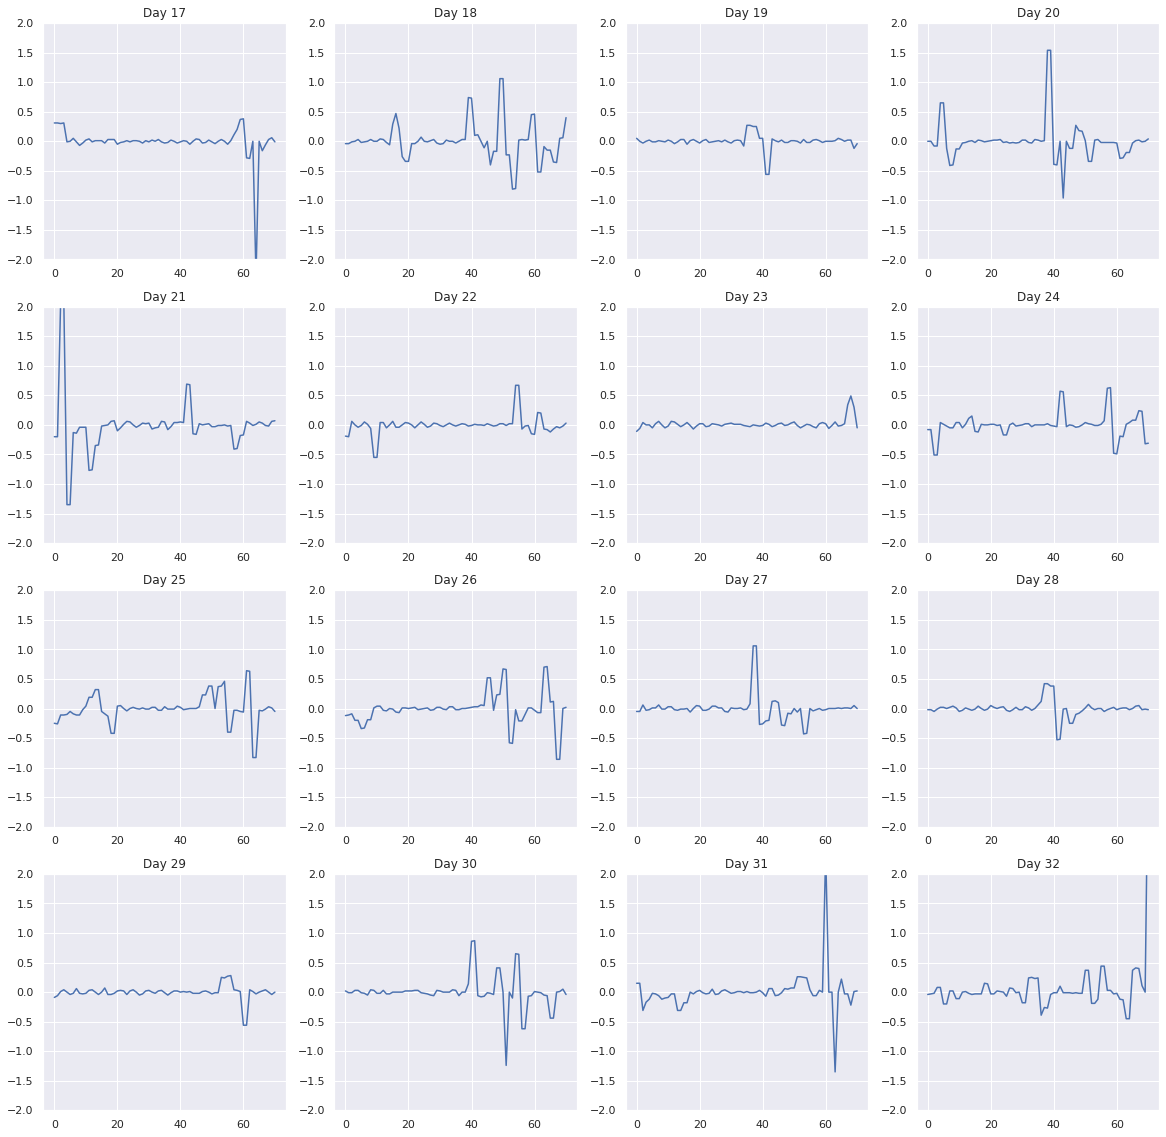

In [ ]:
multi_diff_plot(range(17,34))

In [ ]:
def multi_day_plot_test(day_list):
  """plot graph of power consumption
  
  Parameters
  ----------
  day_list: list
       List of day that you want to observe power consumption. Day should be positive interger and len of list can not longer that 16.
  """
  fig,ax=plt.subplots(4,4)
  fig.set_size_inches(20, 20)

  count=0
  for i in range(4):
    for j in range(4):
      if count < len(day_list):
        data=test.iloc[day_list[count]-1,1:]
        ax[i,j].plot(range(len(data)),data)
        ax[i,j].set_xticks([0,24,48,72,96,120,144])
        ax[i,j].set_xticklabels(['00:00','04:00','08:00','12:00','16:00','20:00','24:00'])
        ax[i,j].set_ylim(0,6)
        ax[i,j].set_ylim(0,6)
        ax[i,j].set_title('Day {}'.format(day_list[count]))
        count+=1
  
  plt.show()

ลองพลอตกราฟครึ่งวันของข้อมูล test set

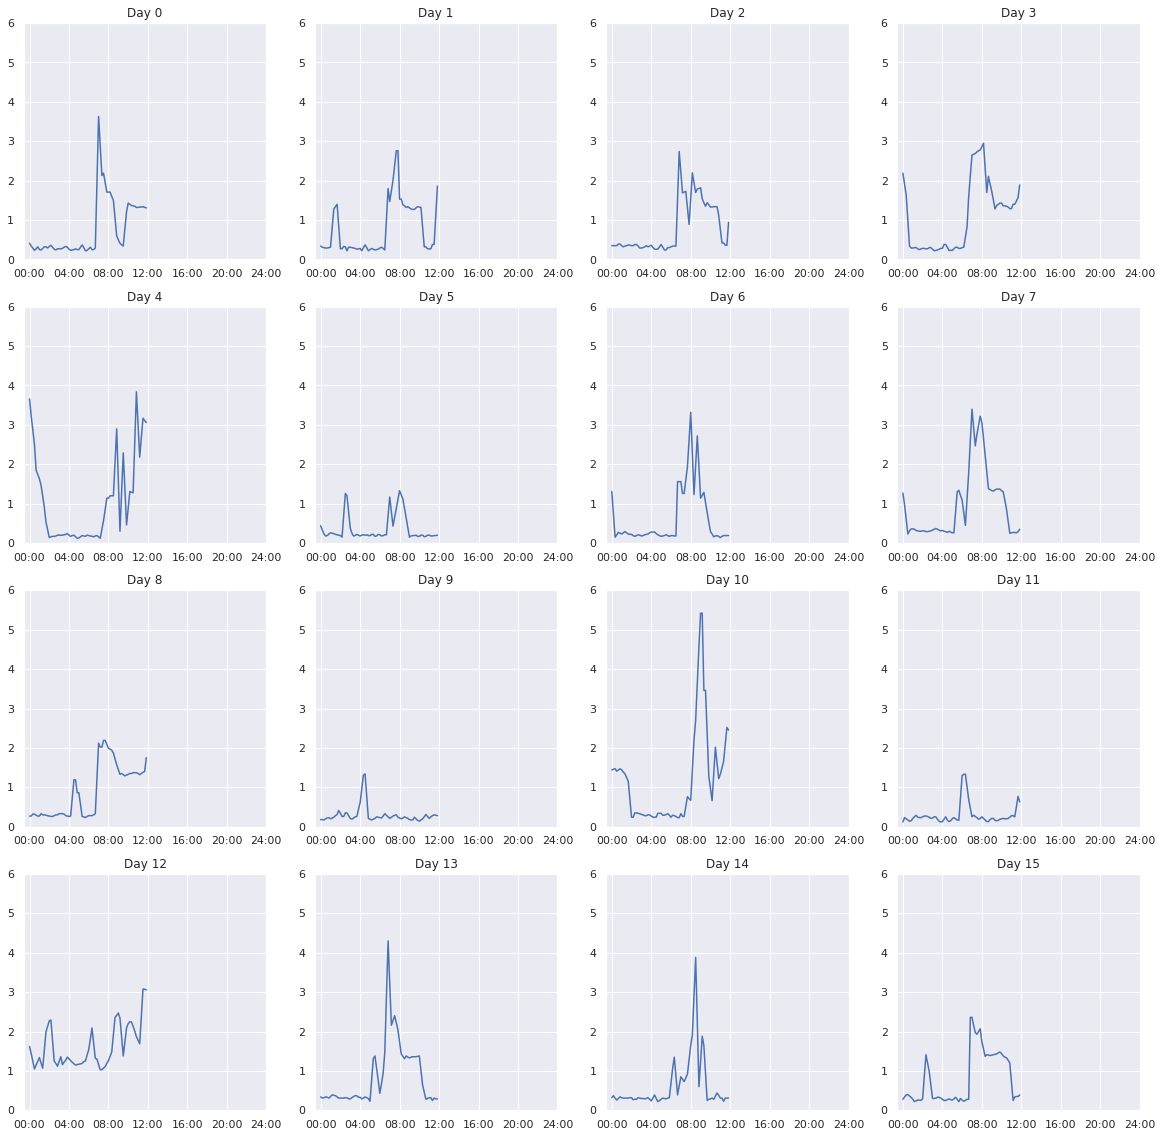

In [ ]:
multi_day_plot_test(range(16))

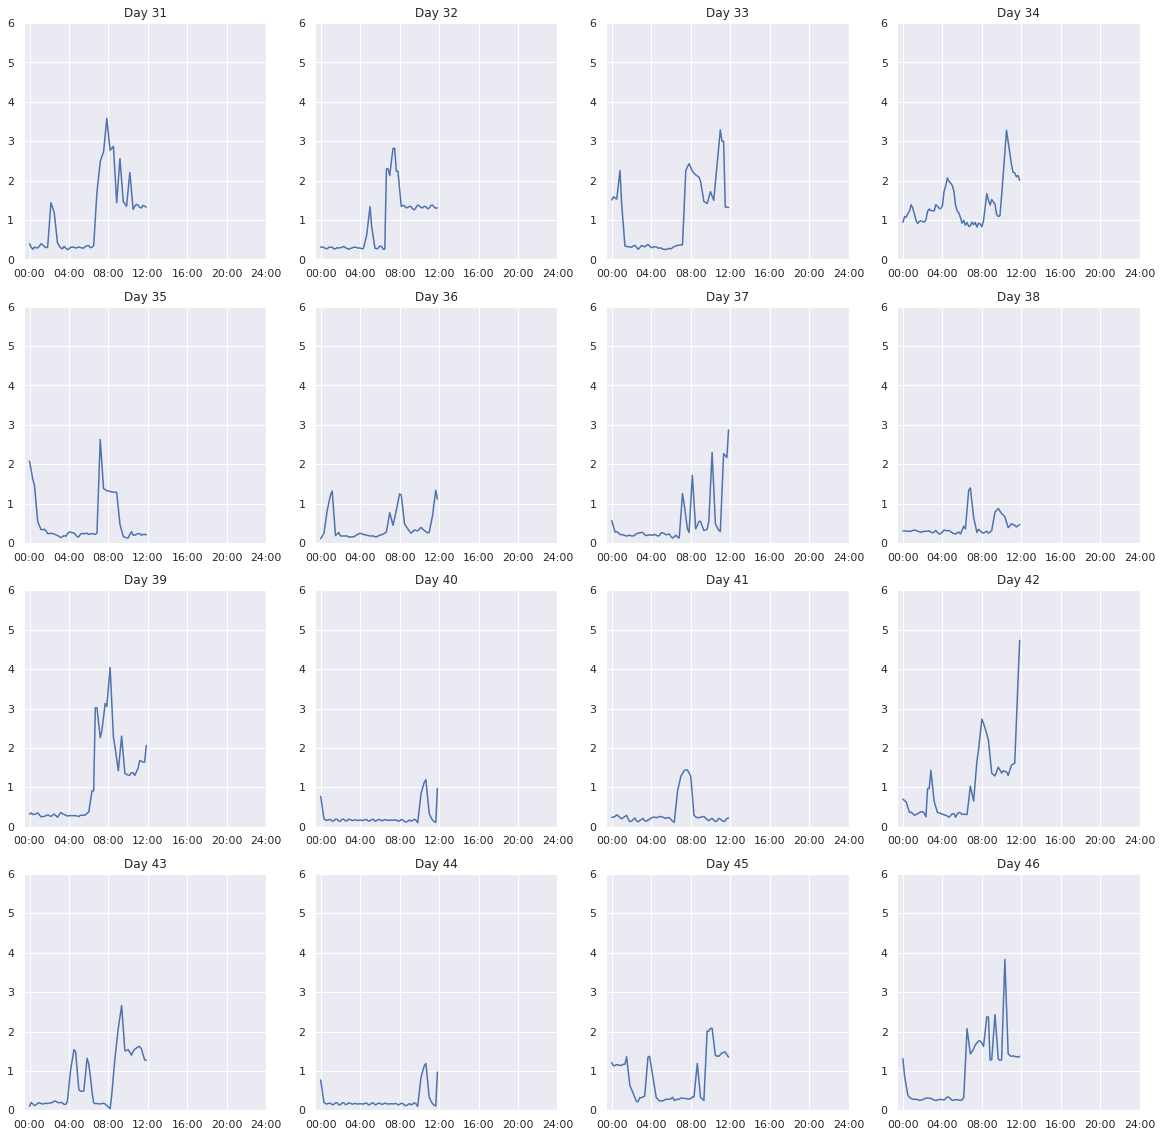

In [ ]:
multi_day_plot_test(range(31,47))